In [12]:
from datasets import load_dataset
from datasets import Dataset
from pathlib import Path

#### Load our data in a dataset object

In [13]:
article_path = Path("data/newsela_article_corpus_2016-01-29/articles")
columns = ["slug", "language", "title", "grade_level", "version", "filename"]
raw_dataset = Dataset.from_csv("data/newsela_article_corpus_2016-01-29/articles_metadata.csv", delimiter=",")

raw_dataset = raw_dataset.rename_column("slug", "id")  # Assuming 'slug' is equivalent to 'id'

def load_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

# Create a function to process and prepare the dataset
def process_dataset(example):
    # Customize this function based on your needs
    return {
        "en": load_file(Path(article_path, example["filename"])), 
        "s_en": load_file(Path(article_path,(example["filename"][:-5]
                                                 +str(1)
                                                 +".txt"))),
        "id": example["filename"]
    }

raw_dataset = raw_dataset.filter(lambda x: int(x["version"]) == 0)
raw_dataset = raw_dataset.filter(lambda x: x["filename"] != "US-Constitution.en.0.txt")
raw_dataset = raw_dataset.filter(lambda x: x['language'] == 'en')

# Apply the processing function to the dataset
processed_dataset = raw_dataset.map(process_dataset)


processed_dataset.set_format(type="torch",
                             columns=["en", "id", "s_en"])

# Print the processed dataset
print(processed_dataset)

Dataset({
    features: ['id', 'language', 'title', 'grade_level', 'version', 'filename', 'en', 's_en'],
    num_rows: 1910
})


#### Check how some datasets look compared to ours

In [14]:
processed_dataset[0]

{'id': '10dollarbill-woman.en.0.txt',
 'en': 'WASHINGTON — An abolitionist. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\nThese are some of the candidates to be the first woman on U.S. currency notes in more than a century. Treasury Secretary Jacob J. Lew announced the plans this week, saying the all-male lineup on American money has gone on long enough.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said at the National Archives in Washington.\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will fan out across the country to solicit suggestions. They\'ve set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some polling.\n\nThe winner in that contest was Harriet Tubman, 

In [15]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [16]:
books = load_dataset("opus_books", "en-fr")
books['train'][0]

{'id': '0', 'translation': {'en': 'The Wanderer', 'fr': 'Le grand Meaulnes'}}

In [17]:
alpaca = load_dataset("tatsu-lab/alpaca")
alpaca["train"][5]

{'instruction': 'Identify the odd one out.',
 'input': 'Twitter, Instagram, Telegram',
 'output': 'Telegram',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the odd one out.\n\n### Input:\nTwitter, Instagram, Telegram\n\n### Response:\nTelegram'}

### Transform our data to be similar to alpaca data 

In [18]:
import re

article_path = Path("data/newsela_article_corpus_2016-01-29/articles")
columns = ["slug", "language", "title", "grade_level", "version", "filename"]
raw_dataset = Dataset.from_csv("data/newsela_article_corpus_2016-01-29/articles_metadata.csv", delimiter=",")

raw_dataset = raw_dataset.rename_column("slug", "id")  # Assuming 'slug' is equivalent to 'id'

def load_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()
    
def format_instruction(en: str, s_en: str, model_type: str="llama"):
    en = re.sub(r'\(?http\S+\)?|<.*?>', '', en) # remove links and html tags
    s_en = re.sub(r'\(?http\S+\)?|<.*?>', '', s_en)
    if model_type == "llama":
        # return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        #     ### Instruction:
        #     Simplify the text.

        #     ### Input:
        #     {en.strip()}

        #     ### Summary:
        #     {s_en}
        #     """.strip()
        return f"""[INST] <<SYS>>
        You are a very helpful assistant, that is highly skilled at simpflying complex english texts. Answer any query correctly.
        <</SYS>>
        
        Slightly simplify the following text, as to make it more accesible:
        {en.strip()}
        [/INST]\nThe slightly simplified version is:\n
        {s_en.strip()}
        </s>""".strip() # level 1
    elif model_type == "mistral":
        # return f"""[INST] Heavily simplify the following text, as to make it accesible even for English speakers with very limited language skills:\n{en.strip()} [/INST]\nThe very simplified version is:\n{s_en}""".strip() # for levels 3-4
        # return f"""[INST] Moderately simplify the following text, as to make it accesible even for English speakers with just below decent language skills:\n{en.strip()} [/INST]\nThe moderately simplified version is:\n{s_en}""".strip() # for level 2
        return f"""[INST] Slightley simplify the following text, as to make it more accesible :\n{en.strip()} [/INST]\nThe slightly simplified version is:\n{s_en}""".strip() # for level 1

# Create a function to process and prepare the dataset
def process_dataset(example):
    # apply preprocessing and tokenization here ??
    en = load_file(Path(article_path, example["filename"]))
    s_en = load_file(Path(article_path,(example["filename"][:-5]
                                                +str(1)
                                                +".txt")))
    return {
        "instruction": "Simplify the text",
        "input": en, 
        "output": s_en,
        "id": example["filename"],
        "text": format_instruction(en, s_en, "llama")
    }

raw_dataset = raw_dataset.filter(lambda x: int(x["version"]) == 0)
raw_dataset = raw_dataset.filter(lambda x: x["filename"] != "US-Constitution.en.0.txt")
raw_dataset = raw_dataset.filter(lambda x: x['language'] == 'en')
raw_dataset = raw_dataset.filter(lambda x: Path(f"data/newsela_article_corpus_2016-01-29/articles/{x['filename'][:-5]}2.txt").exists())

# Apply the processing function to the dataset
alpaca_like_dataset = raw_dataset.map(process_dataset)


alpaca_like_dataset.set_format(type="torch",
                             columns=["instruction", "input", "output", "id", "text"])

# Print the processed dataset
print(alpaca_like_dataset)

Dataset({
    features: ['id', 'language', 'title', 'grade_level', 'version', 'filename', 'instruction', 'input', 'output', 'text'],
    num_rows: 1910
})


In [19]:
alpaca_like_dataset[0]

{'id': '10dollarbill-woman.en.0.txt',
 'instruction': 'Simplify the text',
 'input': 'WASHINGTON — An abolitionist. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\nThese are some of the candidates to be the first woman on U.S. currency notes in more than a century. Treasury Secretary Jacob J. Lew announced the plans this week, saying the all-male lineup on American money has gone on long enough.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said at the National Archives in Washington.\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will fan out across the country to solicit suggestions. They\'ve set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some polling.\n\nThe win

In [20]:
import dill as pickle

with open('data/dataset_llama_l1.pkl', 'wb') as f:
    pickle.dump(alpaca_like_dataset, f)

In [21]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoConfig, PretrainedConfig, BitsAndBytesConfig
from unsloth import FastLanguageModel
import torch


model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "mesolitica/llama-1b-hf-32768-fpf"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

kwargs = {'attn_implementation': 'flash_attention_2'}
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name, # Supports Llama, Mistral - replace this!
    max_seq_length = 4096,
    dtype = None,
    load_in_4bit = True,
    **kwargs
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


In [22]:
lengths = []
for sample in alpaca_like_dataset:
    ids = tokenizer(sample['text'])['input_ids']
    lengths.append(len(ids))

Token indices sequence length is longer than the specified maximum sequence length for this model (4228 > 4096). Running this sequence through the model will result in indexing errors


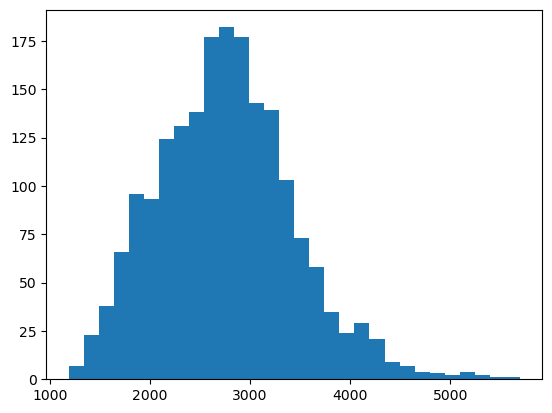

In [23]:
from matplotlib import pyplot as plt
bins, values, _ = plt.hist(lengths, bins=30)

In [13]:
thr = 4096
print(f'There are {sum([b for idx, b in enumerate(bins) if values[idx] > thr])} samples that will be cut off early if we use a context length of {thr}, amounting for a percentage of {sum([b for idx, b in enumerate(bins) if values[idx] > thr])/sum(bins) * 100:.2f}%.')

There are 54.0 samples that will be cut off early if we use a context length of 4096, amounting for a percentage of 2.83%.


: 